### Importing the Libraries

In [ ]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the data after Data Cleaning and some Feature Engineering

In [ ]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_test.pkl')

In [ ]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 309) 


 Test Data Shape : (506691, 308) 

*********************************************


In [ ]:
with open("/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/features_having_covariate_shift.pkl", 'rb') as handle:
  drop_cols = pickle.load(handle)

## Defining the Utility Functions

In [ ]:
'''
 This will return fpr, tpr, threshold and roc_auc.
'''
def tpr_fpr_threshold_auc(Y, proba):
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)

    return (fpr, tpr, threshold, roc_auc)

In [ ]:
'''
  This will draw ROC-AUC Curves for Train and Validation Datasets
'''

def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [ ]:
    '''
        This will return the best threshold value based on the TPR and FPR values.
    '''
def best_threshold(threshold,tpr,fpr):

    return threshold[np.argmax(tpr*(1-fpr))];


    '''
        This wil return the class label based on the chosen threshold.
    '''
def class_label(best_thr, pred_score):

    return np.where(pred_score>best_thr,1,0);

In [ ]:
    '''
        This will draw Confusion Matrix.
    '''

def draw_confusion_matrix(Y, predicted):

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [ ]:
    '''
        This will save the test data predictions locally.
    '''
def predict_and_save(prediction, name):


    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

## Data Preparation
<br>

### Splitting the Dataset

In [ ]:
X = train_data.drop(['isFraud']+drop_cols, axis=1)
y = train_data['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

In [ ]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Cross Validation Data Shape : {} \n".format(X_cv.shape))
print("*"*45)

*********************************************

 Train Data Shape : (472430, 296) 


 Cross Validation Data Shape : (118108, 296) 

*********************************************


<br>

## Modeling

<br>

In [ ]:
'''
  Defining the Model of XGB classifier.
'''

clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.78285
[50]	validation_0-auc:0.85975
[100]	validation_0-auc:0.87604
[150]	validation_0-auc:0.89101
[200]	validation_0-auc:0.90243
[250]	validation_0-auc:0.91003
[300]	validation_0-auc:0.91431
[350]	validation_0-auc:0.91687
[400]	validation_0-auc:0.91905
[450]	validation_0-auc:0.92092
[500]	validation_0-auc:0.92249
[550]	validation_0-auc:0.92352
[600]	validation_0-auc:0.92438
[650]	validation_0-auc:0.92537
[700]	validation_0-auc:0.92602
[750]	validation_0-auc:0.92705
[800]	validation_0-auc:0.92763
[850]	validation_0-auc:0.92854
[900]	validation_0-auc:0.92907
[950]	validation_0-auc:0.92921
[1000]	validation_0-auc:0.92932
[1050]	validation_0-auc:0.92986
[1100]	validation_0-auc:0.93026
[1150]	validation_0-auc:0.93042
[1200]	validation_0-auc:0.93051
[1250]	validation_0-auc:0.93076
[1300]	validation_0-auc:0.93058
[1348]	validation_0-auc:0.93070


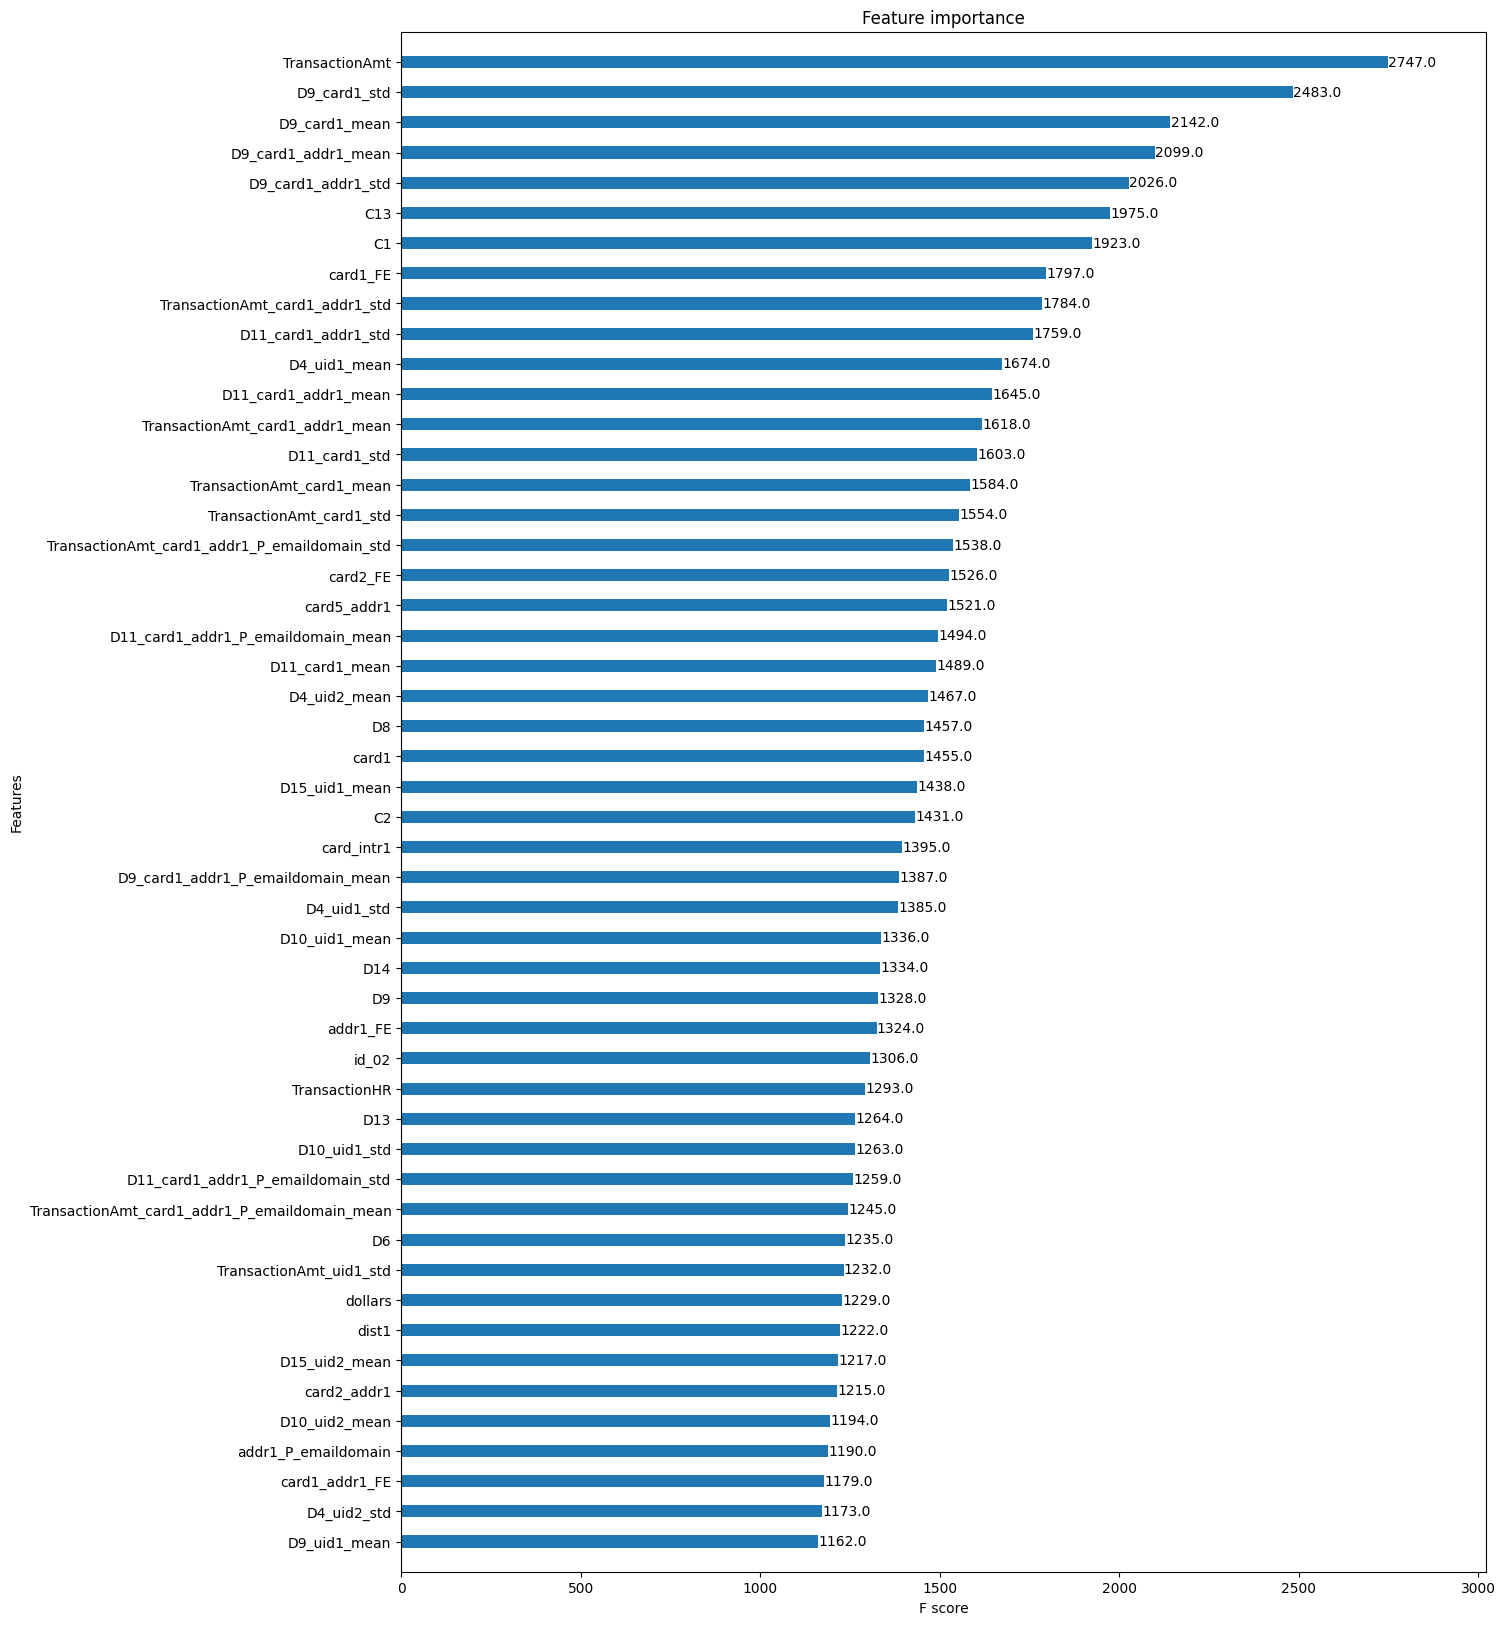

In [ ]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [ ]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]

In [ ]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

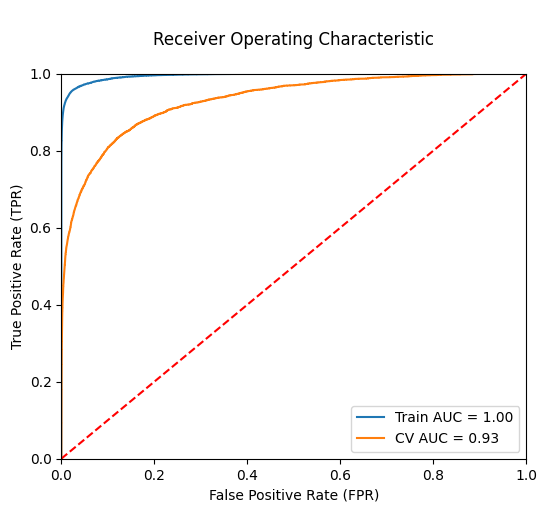

In [ ]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

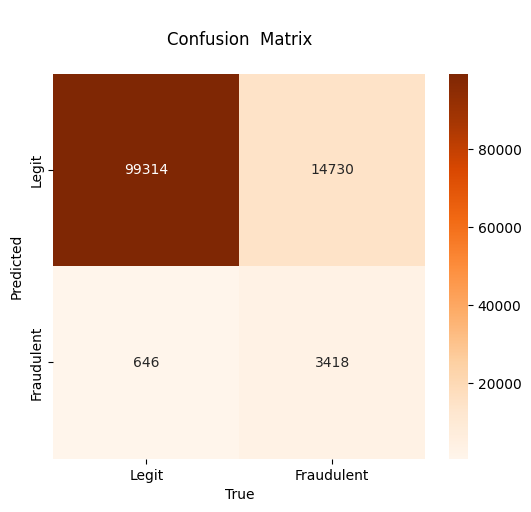

In [ ]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)

In [ ]:
print('\n',metrics.classification_report(y_cv, cv_proba))

In [ ]:
del X_train, y_train

In [ ]:
X_train = train_data.drop('isFraud', axis=1)
y_train = train_data['isFraud']

X_test = test_data
test_ids = test_data['TransactionID'].values

cols = [f for f in X_train if f not in drop_cols]

del train_data, test_data

In [ ]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 308) 


 Test Data Shape : (506691, 308) 

*********************************************


In [ ]:

test_proba = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)

for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=3000,
        tree_method='gpu_hist',
        random_state=3,
        subsample=0.8,
        max_depth=8,
        colsample_bytree=0.6,
        learning_rate=0.02
    )

    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT],
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    test_proba += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits

Fold 0 withholding month 12
 rows of train = 453217 rows of holdout = 137321
[0]	validation_0-auc:0.78099
[100]	validation_0-auc:0.86170
[200]	validation_0-auc:0.88462
[300]	validation_0-auc:0.89610
[400]	validation_0-auc:0.90197
[500]	validation_0-auc:0.90521
[600]	validation_0-auc:0.90689
[700]	validation_0-auc:0.90838
[800]	validation_0-auc:0.90914
[900]	validation_0-auc:0.90975
[1000]	validation_0-auc:0.91010
[1100]	validation_0-auc:0.91009
[1200]	validation_0-auc:0.91018
[1300]	validation_0-auc:0.91013
[1372]	validation_0-auc:0.91018
Fold 1 withholding month 15
 rows of train = 488906 rows of holdout = 101632
[0]	validation_0-auc:0.79631
[100]	validation_0-auc:0.89170
[200]	validation_0-auc:0.91681
[300]	validation_0-auc:0.92795
[400]	validation_0-auc:0.93379
[500]	validation_0-auc:0.93705
[600]	validation_0-auc:0.93914
[700]	validation_0-auc:0.94050
[800]	validation_0-auc:0.94147
[900]	validation_0-auc:0.94193
[1000]	validation_0-auc:0.94225
[1100]	validation_0-auc:0.94241
[1200]

In [ ]:
predict_and_save(test_proba, 'final_submission.csv')